<a href="https://colab.research.google.com/github/robd123/IndepResearch/blob/master/BugClassificationT5_TypeOnly_CrossVal_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
model_name = "t5-small"
token_len = 512
model_prefix = f"{model_name}-{token_len}"

In [ ]:
pip install sentencepiece

     |████████████████████████████████| 1.2 MB 10.0 MB/s 


In [ ]:
#pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl


In [ ]:
#pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

In [ ]:
pip install pytorch-lightning

     |████████████████████████████████| 584 kB 7.3 MB/s 
     |████████████████████████████████| 136 kB 67.2 MB/s 
     |████████████████████████████████| 596 kB 64.5 MB/s 
     |████████████████████████████████| 409 kB 66.4 MB/s 
     |████████████████████████████████| 1.1 MB 32.8 MB/s 
     |████████████████████████████████| 271 kB 58.6 MB/s 
     |████████████████████████████████| 144 kB 55.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install nlp

     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 212 kB 16.2 MB/s 


In [ ]:
pip install transformers

     |████████████████████████████████| 4.0 MB 9.8 MB/s 
     |████████████████████████████████| 6.6 MB 41.0 MB/s 
     |████████████████████████████████| 77 kB 3.4 MB/s 
     |████████████████████████████████| 880 kB 31.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=83a30631a06e6259e97f95f69c63217e8c0afd4c3d0ffb44e83712fefd9776df
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
pip install wandb

     |████████████████████████████████| 1.8 MB 10.0 MB/s 
     |████████████████████████████████| 181 kB 65.6 MB/s 
     |████████████████████████████████| 144 kB 25.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=413f146e98f35c1ad14e5fd08c1a69ca6d2ead301294e57b9ff218fbf68b1a9a
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


In [ ]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import torch
from pytorch_lightning.loggers.wandb import WandbLogger
import os
from pathlib import Path
from string import punctuation

os.environ["WANDB_API_KEY"] = '33461c97826e5a650bb71bec8b3e694e7c6ee9f6'
wandb_logger = WandbLogger(project='bugclassification-t5small')

wandb: Currently logged in as: robd123. Use `wandb login --relogin` to force relogin


In [ ]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import string
import pandas as pd
# pd.set_option('display.max_colwidth', -1)
import numpy as np
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from nlp import load_metric

from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
import random
import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import auth
auth.authenticate_user()

!gcloud config set project eternal-bruin-340122

!gsutil cp gs://robd_indep_research/linux_bugs_usage_ready.csv /tmp/dataset.csv

Updated property [core/project].
Copying gs://robd_indep_research/linux_bugs_usage_ready.csv...
/ [1 files][ 40.8 MiB/ 40.8 MiB]                                                
Operation completed over 1 objects/40.8 MiB.                                     


Text Processing Functions
From https://github.com/Forethought-Technologies/ieee-dsmp-2018-paper/blob/master/text_processing.py

In [ ]:
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

def strip_punctuations(data, column_name='text'):
  '''
  Strips punctuations from the end of each token.
  This uses suggestion from https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate
  to accomplish this really fast.
  '''
  translator = str.maketrans('', '', string.punctuation)
  data['text'] = data['text'].map(lambda s : str(s).translate(translator))
  return data

def stemm_text(data, stemmer_choice='Lancaster'):
  '''
  Stemm the 'text' column of data - this simplifies the words so
  that different forms of the same word end up being the same.
  '''
  if stemmer_choice == 'Lancaster':
    stemmer = LancasterStemmer()
  elif stemmer_choice == 'Snowball':
    stemmer = SnowballStemmer('english')
  elif stemmer_choice == 'Porter':
    stemmer = PorterStemmer()
  else:
    raise Exception('Illegal stemmer_choice argument')
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: stemmer.stem(w), s.split())))
  return data

def remove_long_words(data, maxlen=16):
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if len(w) < maxlen else ' ', s.split())))
  return data

def remove_short_words(data, minlen=4):
  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if len(w) >= minlen else ' ', s.split())))
  return data

def remove_linux_garbage(data):
  '''
  Linux data contains lots of garbage, e.g. memory addresses - 0000f800
  '''
  def is_garbage(w):
    return len(w) >= 7 and sum(c.isdigit() for c in w) >= 2

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if not is_garbage(w) else ' ', s.split())))
  return data

def cast_to_lowercase(data):
  data['text'] = data['text'].map(lambda s : s.lower())
  return data

def remove_stopwords(data):
  stop_words = stopwords.words('english')
  translator = str.maketrans('', '', string.punctuation)
  stop_words = set([w.translate(translator) for w in stop_words]) # Apostrophes were removed already

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if w not in stop_words else ' ', s.split())))
  return data

def remove_rare_words(data, min_count=3):
  wc = {} # WordCount
  def proc_word(s):
    for w in set(s.split()):
      if w in wc:
        wc[w] += 1
      else:
        wc[w] = 1

  for index, row in data.iterrows():
    proc_word(row['text'])

  data['text'] = data['text'].map(lambda s : ' '.join(map(lambda w: w if wc[w] >= min_count else ' ', s.split())))
  return data

In [ ]:
data = pd.read_csv('/tmp/dataset.csv', sep='\t')

In [ ]:
data.head()

,title,message,importance,product,component
0,oops when using ide-cd with 2.5.45 and cdrecord,Please enter Exact Kernel version:2.5.45 Distr...,P2 normal,IO/Storage,IDE
1,NUMA-Q hangs during TSC initialization on boot.,Exact Kernel version: 2.5.46 Distribution: deb...,P2 normal,Platform Specific/Hardware,i386
2,Enabling shared pagetables causes KDE to wierd...,Exact Kernel version: 2.5.46-mm1 Distribution:...,P2 normal,Memory Management,Other
3,Dcache spirals out of control on 2.5.43-mm2,Exact Kernel version: 2.5.43-mm2 Distribution:...,P2 blocking,IO/Storage,Other
4,64GB highmem BUG(),Exact Kernel version: 2.5.40 Hardware Environm...,P2 normal,Memory Management,Other


In [ ]:
  data['text'] = data['title'] + ' ' + data['message']
  data = data.drop(['title'], axis=1)
  data = data.drop(['message'], axis=1)
  data.head()

,importance,product,component,text
0,P2 normal,IO/Storage,IDE,oops when using ide-cd with 2.5.45 and cdrecor...
1,P2 normal,Platform Specific/Hardware,i386,NUMA-Q hangs during TSC initialization on boot...
2,P2 normal,Memory Management,Other,Enabling shared pagetables causes KDE to wierd...
3,P2 blocking,IO/Storage,Other,Dcache spirals out of control on 2.5.43-mm2 Ex...
4,P2 normal,Memory Management,Other,64GB highmem BUG() Exact Kernel version: 2.5.4...


In [ ]:
data['prio'] = [a[:2] for a in data['importance']]
data['type'] = [a[3:] for a in data['importance']]

In [ ]:
data.drop(data[data['type'] == 'blocking'].index, inplace = True)
data.drop(data[data['type'] == 'enhancement'].index, inplace = True)
data.drop(data[data['type'] == 'empty'].index, inplace = True)

In [ ]:
data.head()

,importance,product,component,text,prio,type
0,P2 normal,IO/Storage,IDE,oops when using ide-cd with 2.5.45 and cdrecor...,P2,normal
1,P2 normal,Platform Specific/Hardware,i386,NUMA-Q hangs during TSC initialization on boot...,P2,normal
2,P2 normal,Memory Management,Other,Enabling shared pagetables causes KDE to wierd...,P2,normal
4,P2 normal,Memory Management,Other,64GB highmem BUG() Exact Kernel version: 2.5.4...,P2,normal
5,P2 normal,Memory Management,Slab Allocator,2.5.41 oops in kmem_cache_create Exact Kernel ...,P2,normal


In [ ]:
nltk.download('stopwords')
data = strip_punctuations(data)
data = remove_linux_garbage(data)
data = cast_to_lowercase(data)
data = remove_stopwords(data)
data = remove_rare_words(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data.head()

,importance,product,component,text,prio,type
0,P2 normal,IO/Storage,IDE,oops using idecd 2545 cdrecord please enter ex...,P2,normal
1,P2 normal,Platform Specific/Hardware,i386,numaq hangs tsc initialization boot exact kern...,P2,normal
2,P2 normal,Memory Management,Other,enabling shared pagetables causes kde wierd ex...,P2,normal
4,P2 normal,Memory Management,Other,64gb highmem bug exact kernel version 2540 har...,P2,normal
5,P2 normal,Memory Management,Slab Allocator,2541 oops kmemcachecreate exact kernel version...,P2,normal


In [ ]:
from sklearn.model_selection import train_test_split

X = data['text']
Y = data['type']

X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=11, stratify=Y)


In [ ]:
print(len(Y_train_val))
print(len(Y_test))

12298
3075


In [ ]:
train_val_df = X_train_val.to_frame()
train_val_df['target'] = Y_train_val

In [ ]:
test_df = X_test.to_frame()
test_df['target'] = Y_test

In [ ]:
train_val_df.head()

,text,target
13890,mmcsd mmcsd card reader work kernels higher 26...,normal
3907,driver order attached devices distribution d...,normal
9400,regression softlockup fix subject regression s...,normal
10400,x86 tsc prevent time going backwards broke sus...,normal
6656,kernel frozen removal sata disk raid1 issue ...,normal


In [ ]:
train_val_df['target'].value_counts()

normal    9376
high      2155
low        767
Name: target, dtype: int64

In [ ]:
test_df['target'].value_counts(normalize=True)

normal    0.762276
high      0.175285
low       0.062439
Name: target, dtype: float64

In [ ]:
data.shape

(15373, 6)

In [ ]:
import numpy as np
import pandas as pd


class BugData(Dataset):
    def __init__(self, df, tokenizer, type_path, num_samples, input_length=4096, output_length=4096, print_text=False):         
        self.dataset = []
        inps = df["text"].values.tolist()
        lbls = df["target"].values.tolist()

        for i, inp in enumerate(inps):
            inp = inp.replace(":", "")
            inp = "classify: " + inp
            lbl = str(lbls[i])
            self.dataset.append({"inp": inp, "lbl": lbl})
        
        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.print_text = print_text
        
  
    def __len__(self):
        return len(self.dataset)

    def convert_to_features(self, example_batch):
        
        input_ = example_batch['inp']
        target_ = example_batch['lbl']
    
        
        input_ = input_.strip()

        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")

        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

def get_dataset(tokenizer, type_path, num_samples, args):
      if type_path == 'train':
          return BugData(train_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)
      elif type_path == 'validation':
            return BugData(val_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)
      elif type_path == 'test':
            return BugData(test_df, tokenizer=tokenizer, type_path=type_path, num_samples=num_samples, input_length=args.max_input_length, 
              output_length=args.max_output_length)


In [ ]:
fold_number = 0 #Used to track the fold number for WandB logging
class T5BugClassifier(pl.LightningModule):
    def __init__(self, hparams):
        super(T5BugClassifier, self).__init__()
        self.save_hyperparameters(hparams)        
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path, return_dict=True)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path, max_length=hparams.max_input_length)
        self.output_dir = Path(self.hparams.output_dir)
        self.step_count = 0
        
    def forward(self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None):
        return self.model(
                input_ids,
                attention_mask=attention_mask,
                decoder_input_ids=decoder_input_ids,
                decoder_attention_mask=decoder_attention_mask,
                labels=lm_labels
            )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss
    
    def _generative_step(self, batch) :
        t0 = time.time()
        loss = self._step(batch)
        base_metrics = {'val_loss': loss}
        self.log("val/loss_fold" + str(fold_number), loss, on_step=False, on_epoch=True)
        return base_metrics

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        return self._generative_step(batch)

    def configure_optimizers(self):

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]
  
    
    def train_dataloader(self):   
        train_dataset = get_dataset(tokenizer=self.tokenizer, type_path="train", num_samples=-1, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=1)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler

        return dataloader

    def val_dataloader(self):
        validation_dataset = get_dataset(tokenizer=self.tokenizer, type_path="validation", num_samples=-1, args=self.hparams)
        
        return DataLoader(validation_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    def test_dataloader(self):
        test_dataset = get_dataset(tokenizer=self.tokenizer, type_path="test", num_samples=-1, args=self.hparams)
        
        return DataLoader(test_dataset, batch_size=self.hparams.eval_batch_size, num_workers=1)
    
    def on_save_checkpoint(self, checkpoint):
        save_path = self.output_dir.joinpath(model_prefix)
        self.model.config.save_step = self.step_count
        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

In [ ]:
args_dict = dict(
    output_dir="", # path to save the checkpoints
    model_name_or_path=model_name,
    tokenizer_name_or_path=model_name,
    max_input_length=token_len,
    max_output_length=token_len,
    freeze_encoder=False,
    freeze_embeds=False,
    learning_rate=2e-5,
    weight_decay=0.1,
    adam_epsilon=1e-8,
    warmup_steps=0,
    train_batch_size=6,
    eval_batch_size=6,
    num_train_epochs=6,
    n_gpu=1,
    gradient_accumulation_steps=8,
    val_check_interval = 0.5, 
    n_val=-1,
    n_train=-1,
    n_test=-1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)


args_dict.update({'output_dir': "./" + model_prefix + "_final", 'num_train_epochs':50,
             'train_batch_size': 8, 'eval_batch_size': 8, 'resume_from_checkpoint' : 't5-small-512t5-small-512_ckpt_epoch_29.ckpt'})
args = argparse.Namespace(**args_dict)



In [ ]:
train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    precision= 16 if args.fp_16 else 32,
    amp_backend='apex',
    #tpu_cores=8,
    gpus=1,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    val_check_interval=args.val_check_interval,
    logger=wandb_logger,
    max_epochs=4,
)

model = T5BugClassifier(args)
trainer = pl.Trainer(**train_params)

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
torch.cuda.empty_cache()

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
X_train_val = train_val_df['text']
Y_train_val = train_val_df['target']
skf.get_n_splits(X_train_val, Y_train_val)
for train_index, test_index in skf.split(X_train_val, Y_train_val):
  X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
  Y_train, Y_val = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
  train_df = X_train.to_frame()
  train_df['target'] = Y_train
  val_df = X_val.to_frame()
  val_df['target'] = Y_val
  trainer = pl.Trainer(**train_params)
  trainer.fit(model)
  fold_number = fold_number + 1


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /content/bugclassification-t5small/3jak8319/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
242.026   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
torch.save(model.state_dict(), '/content/sample_data/bc_type_cv_full_t5_model_2.pt')

In [ ]:
!gsutil cp /content/sample_data/bc_type_cv_full_t5_model_2.pt gs://robd_indep_research/Results

Copying file:///content/sample_data/bc_type_cv_full_t5_model_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/230.9 MiB.                                    


In [ ]:
!gsutil cp gs://robd_indep_research/Results/bc_type_cv_full_t5_model_2.pt /content/sample_data/ 

Copying gs://robd_indep_research/Results/bc_type_cv_full_t5_model_2.pt...
\ [1 files][230.9 MiB/230.9 MiB]                                                
Operation completed over 1 objects/230.9 MiB.                                    


In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')
df = test_df.copy()
dataset = BugData(df, tokenizer, 'test', None, token_len, 3, True)
data_len = len(dataset)
print(data_len)

3075


**Only use this if you are loading a saved model**

In [ ]:
model = T5BugClassifier(args)
model.load_state_dict(torch.load('/content/sample_data/bc_type_cv_full_t5_model_2.pt'))

<All keys matched successfully>

In [ ]:
loader = DataLoader(dataset, batch_size=128, shuffle=True)
it = iter(loader)

In [ ]:
model.to('cuda')
dec = []
texts = []
targets = []
num = 0;
for batch in it:
  outs = model.model.generate(
            batch["source_ids"].cuda(),
            attention_mask=batch["source_mask"].cuda(),
            use_cache=True,
            decoder_attention_mask=batch['target_mask'].cuda(),
        )
  dec.extend([tokenizer.decode(ids) for ids in outs])
  texts.extend([tokenizer.decode(ids) for ids in batch['source_ids']])
  targets.extend([tokenizer.decode(ids) for ids in batch['target_ids']])

In [ ]:
import textwrap
from tqdm.auto import tqdm

In [ ]:
targets2 = [a.replace("<pad>", "").replace(" ", "").replace("</s>", "") for a in targets]
dec2 = [a.replace("<pad>", "").replace("</s>", "").replace(" ", "") for a in dec]

In [ ]:
print(targets2[0])
print(dec2[0])

normal
normal


In [ ]:
tar_df = pd.DataFrame(targets2)
dec_df = pd.DataFrame(dec2)
tar_df.to_csv('/target_type_out.csv')
dec_df.to_csv('/pred_type_out.csv')

In [ ]:
len(targets2)

3075

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
confusion_matrix(targets2, dec2)

array([[  55,    0,  484],
       [   8,    4,  180],
       [  82,    7, 2255]])

In [ ]:
tar_df = pd.DataFrame(targets2)
tar_df[0].value_counts()

normal    2344
high       539
low        192
Name: 0, dtype: int64

In [ ]:
dec_df = pd.DataFrame(dec2)
dec_df[0].value_counts()

normal    2919
high       145
low         11
Name: 0, dtype: int64

In [ ]:
accuracy_score(targets2, dec2)

0.7525203252032521

In [ ]:
print(classification_report(targets2, dec2))

              precision    recall  f1-score   support

        high       0.38      0.10      0.16       539
         low       0.36      0.02      0.04       192
      normal       0.77      0.96      0.86      2344

    accuracy                           0.75      3075
   macro avg       0.51      0.36      0.35      3075
weighted avg       0.68      0.75      0.68      3075



In [ ]:
confusion_matrix(targets2, dec2)

array([[  55,    0,  484],
       [   8,    4,  180],
       [  82,    7, 2255]])

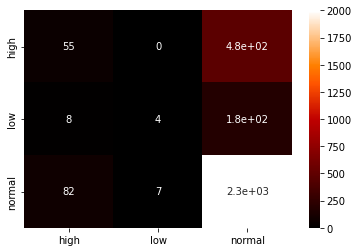

In [ ]:
cm = confusion_matrix(targets2, dec2)
labels = ['high', 'low', 'normal']
sns.heatmap(cm, cmap='gist_heat', annot=True, vmax=2000, xticklabels=labels, yticklabels=labels)